## Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
## Here all analysis is performed based on movies so we will be using movieId as the primary key. 
## Loading and re-sorting the datasets based on the set key

movie_data = pd.read_csv('movies.csv')
ratings_data = pd.read_csv('ratings.csv')
    
# Organise a bit and store into feather-format
movie_data.sort_values(by='movieId', inplace=True)
movie_data.reset_index(inplace=True, drop=True)
ratings_data.sort_values(by='movieId', inplace=True)
ratings_data.reset_index(inplace=True, drop=True)

print(ratings_data.dtypes)

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [3]:
#Splitting the movie title data to year gives an idea of movies released by the year and which genre were they

# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movie_data['year'] = movie_data.title.str.extract("\((\d{4})\)", expand=True)
movie_data.year = pd.to_datetime(movie_data.year, format='%Y')
movie_data.year = movie_data.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movie_data.title = movie_data.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movie_data.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movie_data = movie_data.join(movie_data.genres.str.get_dummies().astype(bool))
movie_data.drop('genres', inplace=True, axis=1)


In [4]:
# Check and clean NaN values
print ("Number of movies Null values: ", max(movie_data.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings_data.isnull().sum()))
movie_data.dropna(inplace=True)
ratings_data.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movie_data.sort_values(by='movieId', inplace=True)
ratings_data.sort_values(by='movieId', inplace=True)
movie_data.reset_index(inplace=True, drop=True)
ratings_data.reset_index(inplace=True, drop=True)

Number of movies Null values:  22
Number of ratings Null values:  0


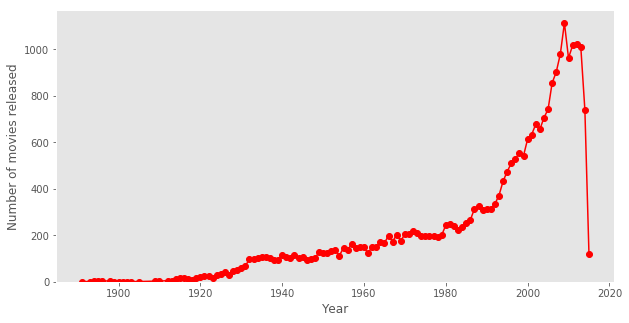

In [5]:
# Grouping by year to get more insight about the yearly distribution
tmpSlice = movie_data[['movieId', 'year']].groupby('year')

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(tmpSlice.year.first(), tmpSlice.movieId.nunique(), "r-o")
ax.grid(None)
ax.set_ylim(0,)


ax.set_xlabel('Year')
ax.set_ylabel('Number of movies released'); 
plt.show()
%reset_selective -f (^tmpSlice$)

<Figure size 720x360 with 0 Axes>

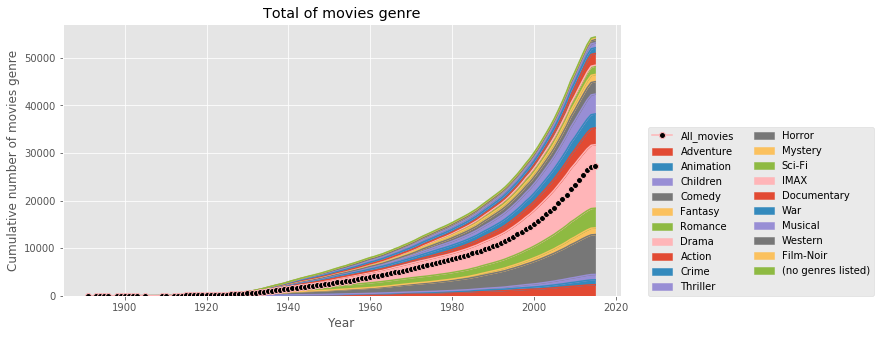

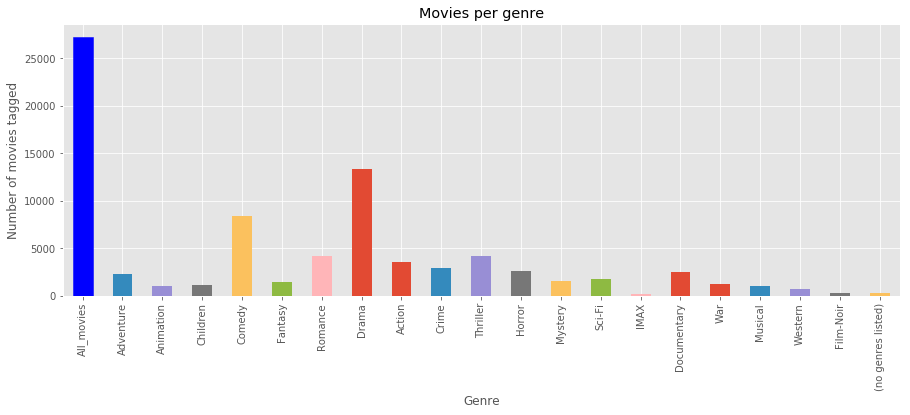

In [6]:
plt.figure(figsize=(10,5))
tmpSlice = movie_data[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : tmpSlice.movieId.nunique().cumsum()})
# Plot histogram for each individual genre
for genre in genres_unique.genre:
    tmpSlice = movie_data[movie_data[genre]][['movieId', 'year']].groupby('year')
    df[genre]=tmpSlice.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies genre')
plt.title('Total of movies genre') # Count of all the genre for all the movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b')
plt.xticks(rotation='vertical')
plt.title('Movies per genre')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

%reset_selective -f (^barlist$|^tmpSlice$|^genre$)


d:\Anaconda3\envs\mlExp\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


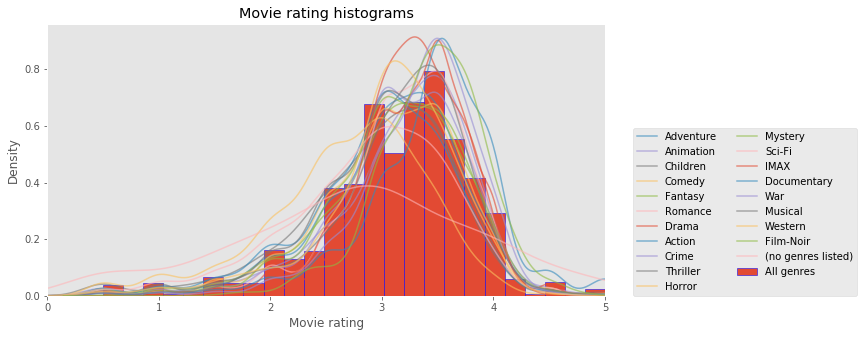

In [7]:
tmpSlice = ratings_data[['movieId','rating']].groupby('movieId').mean()

# Initialize empty list to capture basic stats by gere
rating_stats = []
# Plot general histogram of all ratings
tmpSlice.hist(bins=25, grid=False, edgecolor='b', normed=True, label ='All genres', figsize=(10,5))
# Plot histograms (kde lines for better visibility) per genre
for genre in genres_unique.genre:
    tmpSlice = movie_data[movie_data[genre]==True]
    tmpSlice = ratings_data[ratings_data.set_index('movieId').index.isin(tmpSlice.set_index('movieId').index)]
    tmpSlice = tmpSlice[['movieId','rating']].groupby('movieId').mean()
    tmpSlice.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre)
    avg = tmpSlice.rating.mean()
    std = tmpSlice.rating.std()
    rating_stats.append((genre, avg, std))
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

# Housekeeping
%reset_selective -f (^avg$|^tmpSlice$|^genre$|^std$)

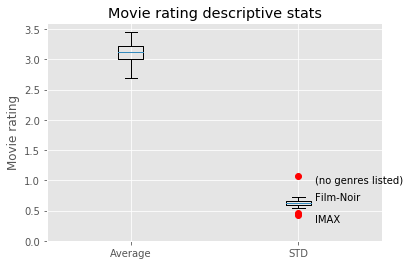

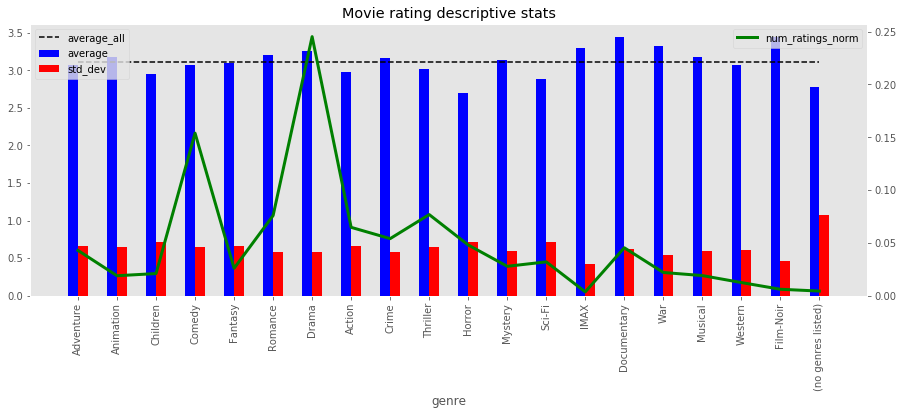

Outliers:  {'IMAX', '(no genres listed)', 'Film-Noir'}
genre             Adventure  Animation  Children    Comedy   Fantasy  \
average            3.072407   3.177095  2.955608  3.074271  3.093084   
std_dev            0.658817   0.652727  0.711403  0.648962  0.661956   
num_ratings_norm   0.042831   0.018887  0.020947  0.153910  0.025949   
average_all        3.112275   3.112275  3.112275  3.112275  3.112275   

genre              Romance     Drama    Action     Crime  Thriller    Horror  \
average           3.205743  3.262057  2.976834  3.166853  3.016069  2.696796   
std_dev           0.583832  0.581126  0.665900  0.584603  0.643598  0.720493   
num_ratings_norm  0.075897  0.245329  0.064716  0.054031  0.076817  0.048018   
average_all       3.112275  3.112275  3.112275  3.112275  3.112275  3.112275   

genre              Mystery    Sci-Fi      IMAX  Documentary       War  \
average           3.134997  2.889511  3.294670     3.436628  3.321137   
std_dev           0.593284  0.720313 

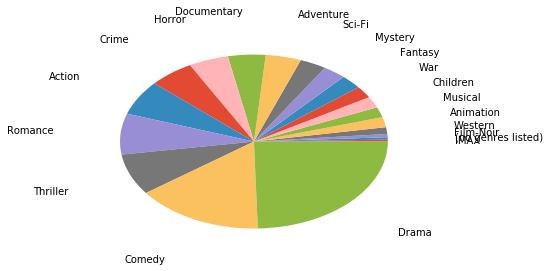

In [8]:
# Construct a DataFrame with all the basic stats per genre
rating_sum = pd.DataFrame(rating_stats,  columns=['genre', 'average', 'std_dev'])
rating_sum.set_index('genre', inplace=True)
# Display a boxplot to show the dispersion of average and standard deviation
bxplot = plt.boxplot(rating_sum.T, labels=['Average', 'STD'], sym="ro")
# Properly label the outliers
outliers = []
for i, value in enumerate(bxplot['fliers']):
    for val in value.get_ydata():
        bxplot_label = rating_sum.index[rating_sum.iloc[:, i] == val][0]
        outliers.append(bxplot_label)
        plt.annotate(bxplot_label, xy=(i+1.1, val+np.random.uniform(-0.25,0.25))) # Trick to prevent overlapping
outliers = set(outliers)
plt.ylim(0,)
plt.ylabel('Movie rating')
plt.title('Movie rating descriptive stats')
plt.show()

# Bar chart with average rating, standard deviation and normalized number of ratings per genre
# Calculate the normalized number of ratings per genre
rating_sum['num_ratings_norm']=df.iloc[-1, 1:]/df.iloc[-1, 1:].sum()
# Calculate the average rating for all genres
rating_sum['average_all']=rating_sum.average.mean()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

rating_sum[['average', 'std_dev']].plot(kind='bar', color=['b','r'], ax=ax, position=0.5, grid=False)
rating_sum['average_all'].plot(kind='line',style='--', color=['black'], ax=ax, grid=False)
rating_sum['num_ratings_norm'].plot(kind='line', color='g', ax=ax2, grid=False, linewidth=3)

ax.legend(loc=2)
ax2.legend(loc=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Movie rating descriptive stats')
plt.autoscale()
ax2.set_ylim(0,)
plt.show()

print("Outliers: ", outliers)
print(rating_sum.T)

# Quick pie chart to visualize how 3 genres take almost 50% of ratings
rating_sum.sort_values(by='num_ratings_norm', inplace=True)
plt.pie(rating_sum['num_ratings_norm'], labels=rating_sum.T.columns, labeldistance=1.5)
plt.show()


# Housekeeping
%reset_selective -f (^avg$|ax|bxplot|^df$|^tmpSlice$|^i$|^rating_stats$|^rating_sum$|^val$|^value$)



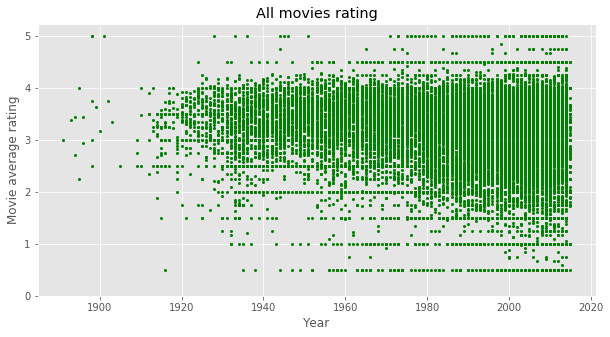

In [9]:
tmpSlice = movie_data[['movieId', 'year']].set_index('movieId').join(
    ratings_data[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(tmpSlice.year, tmpSlice.rating,"g.", markersize=4)
plt.xlabel('Year')
plt.ylabel('Movie average rating')
plt.title('All movies rating')
plt.ylim(0,)
plt.show()

%reset_selective -f (^tmpSlice$)


## Simple Recommendation system

In [1]:
import pandas as pd
import numpy as np

In [2]:
movie_data = pd.read_csv('movies.csv')

In [3]:
ratings = pd.read_csv('ratings.csv')

In [4]:
ratings.dropna(axis = 0, inplace=True)

In [5]:
movie_data = movie_data.merge(ratings.groupby('movieId')['rating'].sum().reset_index(), on = 'movieId', how='inner')

In [6]:
movie_data= movie_data.merge(ratings.groupby('movieId')['userId'].count().reset_index(), on = 'movieId', how='inner')

In [7]:
movie_data.rename(columns={'rating':'avg_rating', 'userId':'vote_count'}, inplace=True)

In [8]:
movie_data['avg_rating'] = movie_data['avg_rating']/movie_data['vote_count']

In [9]:
mean_rating = movie_data.avg_rating.mean()

In [10]:
vote_count_threshold = movie_data.vote_count.quantile(0.90)

In [11]:
q_movies = movie_data.copy().loc[movie_data['vote_count'] >= vote_count_threshold]

In [12]:
def getWeightedRating(x, m=vote_count_threshold, C=mean_rating):
    v = x['vote_count']
    R = x['avg_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [13]:
q_movies['score'] = q_movies.apply(lambda x: getWeightedRating(x), axis = 1)

In [14]:
q_movies = q_movies.sort_values('score', ascending=False)

In [15]:
q_movies[['title', 'vote_count', 'avg_rating', 'score']].head(15)

,title,vote_count,avg_rating,score
315,"Shawshank Redemption, The (1994)",63366,4.446990,4.420466
843,"Godfather, The (1972)",41355,4.364732,4.327039
49,"Usual Suspects, The (1995)",47006,4.334372,4.301909
523,Schindler's List (1993),50054,4.310175,4.280253
1195,"Godfather: Part II, The (1974)",27398,4.275641,4.223672
1169,One Flew Over the Cuckoo's Nest (1975),29932,4.248079,4.201478
895,Casablanca (1942),24349,4.258327,4.201063
2873,Fight Club (1999),40106,4.227123,4.192632
887,Rear Window (1954),17449,4.271334,4.192097
737,Dr. Strangelove or: How I Learned to Stop Worr...,23220,4.247287,4.187975


## Content Based Recommender System

In [16]:
movie_data['year'] = movie_data.title.str.extract("\((\d{4})\)", expand=True)
movie_data.year = pd.to_datetime(movie_data.year, format='%Y')
movie_data.year = movie_data.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movie_data.title = movie_data.title.str[:-7]

In [17]:
genres_unique = pd.DataFrame(movie_data.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movie_data = movie_data.join(movie_data.genres.str.get_dummies().astype(bool))
movie_data.drop('genres', inplace=True, axis=1)

In [18]:
movie_data.dropna(inplace=True)
movie_data.sort_values(by='movieId', inplace=True)
movie_data.reset_index(inplace=True, drop=True)

In [19]:
movie_data.shape

(26722, 25)

In [20]:
from sklearn.neighbors import NearestNeighbors as KNN

In [21]:
def getRatingClass(x):
    if x >= 4.5:
        return 5
    if x >= 3.5 and x < 4.5: return 4
    if x >= 2.5 and x < 3.5 : return 3
    if x >= 1.5 and x < 2.5: return 2
    else: return 0 
def getWeightedRating(x, m=vote_count_threshold, C=mean_rating):
    v = x['vote_count']
    R = x['avg_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [22]:
title = movie_data['title']
#movie_data['class_rating'] = movie_data.avg_rating.apply(lambda x:getRatingClass(x))
movie_data.drop('title', inplace=True, axis=1)

In [23]:
movie_knn = KNN(n_neighbors=10, algorithm='ball_tree').fit(movie_data)

In [24]:
distances, indices = movie_knn.kneighbors(movie_data)

In [25]:
topChoices = {}
for items in range(0, len(indices)):
    titles = title[items]
    topChoices[titles] = [title[i] for i in indices[items][1:]]

In [26]:
topChoices['Shawshank Redemption, The']

['Silence of the Lambs, The',
 'Forrest Gump',
 'Jurassic Park',
 'Pulp Fiction',
 'Star Wars: Episode IV - A New Hope',
 'Braveheart',
 'Terminator 2: Judgment Day',
 'Matrix, The',
 "Schindler's List"]

### Explanation

In the first recommender system - we use only ratings. The recommendations are made only on weighted ratings for each movie. 
A more complex recommender system is the second one. Here the details regarding scores as well as genre have been taken. We can make
it more detailes, by adding tags information, or using word to vec information for genre to capture more details about the movies.